<a href="https://colab.research.google.com/github/jasonnho/flygaruda-sentiment-analysis/blob/main/Tugas%20A-1/Tugas_A_1_PBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!pip -q install scikit-learn==1.5.2 matplotlib==3.9.2 pandas==2.2.3 imbalanced-learn==0.12.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 23.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [2]:
import os, re
import pandas as pd
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns

# Data Setup

In [4]:
df = pd.read_csv("7-garudaindonesia_news_cleaned_simple (1).csv")

df.head()

,link,judul,konten,tanggal,portal,tag,konten_hapus_karakter,konten_normalized,konten_nostop,konten_stem,konten_stem_clean,sentiment,tag_new
0,https://kumparan.com/kumparanbisnis/garuda-ind...,Garuda Indonesia Kembali RUPSLB di Tengah Isu ...,Garuda Indonesia Kembali RUPSLB di Tengah Isu ...,30/09/2025,Kumparan,Manajemen,garuda indonesia kembali rupslb di tengah isu ...,garuda indonesia kembali rupslb di tengah isu ...,garuda indonesia rupslb tengah isu petinggi si...,garuda indonesia rupslb tengah isu petinggi si...,garuda indonesia rupslb tengah isu petinggi si...,Neutral,Kinerja & Keuangan
1,https://www.bloombergtechnoz.com/detail-news/8...,Garuda Gelar RUPSLB di Tengah Isu Masuknya Dir...,Garuda Gelar RUPSLB di Tengah Isu Masuknya Dir...,29/09/2025,Bloomberg Technoz,Manajemen,garuda gelar rupslb di tengah isu masuknya dir...,garuda gelar rupslb di tengah isu masuknya dir...,garuda gelar rupslb tengah isu masuknya direks...,garuda gelar rupslb tengah isu masuk direksi a...,garuda gelar rupslb tengah isu masuk direksi a...,Neutral,Regulasi & Kebijakan
2,https://voi.id/ekonomi/519004/komisi-v-dpr-bak...,Komisi V DPR Bakal Dalami Dugaan Mafia Jual Be...,JAKARTA - Ketua Komisi V DPR Lasarus mengataka...,29/09/2025,VOI.ID,Rute/Operasional,jakarta ketua komisi v dpr lasarus mengatakan ...,jakarta ketua komisi v dpr lasarus mengatakan ...,jakarta ketua komisi v dpr lasarus mengatakan ...,jakarta ketua komisi v dpr lasarus kata dalam ...,jakarta ketua komisi v dpr lasarus kata dalam ...,Negative,Krisis & Kontroversi
3,https://www.kompasiana.com/zainularifin2714/68...,Rencana Merger Garuda Indonesia - Pelita Air: ...,"Latar Belakang\nPada pertengahan 2023, wacana ...",29/09/2025,Kompasiana.com,Lainnya,latar belakang pada pertengahan wacana konsoli...,latar belakang pada pertengahan wacana konsoli...,latar belakang pertengahan wacana konsolidasi ...,latar belakang tengah wacana konsolidasi maska...,latar belakang tengah wacana konsolidasi maska...,Neutral,Kinerja & Keuangan
4,https://www.cnnindonesia.com/ekonomi/202509292...,Dony Oskaria Pastikan Merger Pelita Air-Garuda...,--\nPlt Menteri Badan Usaha Milik Negara (BUMN...,29/09/2025,CNN Indonesia,Lainnya,plt menteri badan usaha milik negara bumn seka...,plt menteri badan usaha milik negara bumn seka...,plt menteri badan usaha milik negara bumn seka...,plt menteri badan usaha milik negara bumn seka...,plt menteri badan usaha milik negara bumn seka...,Neutral,Operasional & Pelayanan


In [5]:
df_base = df[["konten_stem_clean", "sentiment", "tag_new"]].copy()

In [6]:
before = len(df_base)
df_base = df_base.dropna(subset=["konten_stem_clean", "sentiment", "tag_new"])
df_base = df_base.drop_duplicates(subset=["konten_stem_clean"]).reset_index(drop=True)
after = len(df_base)

print(f"Jumlah baris awal: {before} | setelah clean: {after} | terbuang: {before-after}")

Jumlah baris awal: 469 | setelah clean: 469 | terbuang: 0


In [7]:
print("\nDistribusi SENTIMENT:")
print(df_base["sentiment"].value_counts(dropna=False))

print("\nDistribusi CATEGORY (tag_new):")
print(df_base["tag_new"].value_counts(dropna=False))


Distribusi SENTIMENT:
sentiment
Positive    201
Negative    183
Neutral      85
Name: count, dtype: int64

Distribusi CATEGORY (tag_new):
tag_new
Operasional & Pelayanan           185
Krisis & Kontroversi              143
Kinerja & Keuangan                109
Regulasi & Kebijakan               27
Industri & Pariwisata Nasional      5
Name: count, dtype: int64


In [8]:
# --- 7) Contoh 5 baris ---
print("\nContoh data:")
display(df_base.head(5))


Contoh data:


,konten_stem_clean,sentiment,tag_new
0,garuda indonesia rupslb tengah isu petinggi si...,Neutral,Kinerja & Keuangan
1,garuda gelar rupslb tengah isu masuk direksi a...,Neutral,Regulasi & Kebijakan
2,jakarta ketua komisi v dpr lasarus kata dalam ...,Negative,Krisis & Kontroversi
3,latar belakang tengah wacana konsolidasi maska...,Neutral,Kinerja & Keuangan
4,plt menteri badan usaha milik negara bumn seka...,Neutral,Operasional & Pelayanan


# Split Data

In [9]:
# Ambil kolom
X = df_base["konten_stem_clean"].astype(str).values
y_sent = df_base["sentiment"].astype(str).values
y_cat  = df_base["tag_new"].astype(str).values

# Stratified split berdasarkan label sentiment
X_train, X_test, y_sent_train, y_sent_test, y_cat_train, y_cat_test = train_test_split(
    X, y_sent, y_cat,
    test_size=0.2,
    random_state=42,
    stratify=y_sent
)

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")

Train size: 375 | Test size: 94


In [10]:
print("\nDistribusi sentiment di TRAIN:")
print(pd.Series(y_sent_train).value_counts(normalize=True).round(3))

print("\nDistribusi sentiment di TEST:")
print(pd.Series(y_sent_test).value_counts(normalize=True).round(3))


Distribusi sentiment di TRAIN:
Positive    0.429
Negative    0.389
Neutral     0.181
Name: proportion, dtype: float64

Distribusi sentiment di TEST:
Positive    0.426
Negative    0.394
Neutral     0.181
Name: proportion, dtype: float64


# Modelling Baseline



In [11]:
# STEP 3 — Build & Train Baseline Model (BoW + MultinomialNB)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Fungsi pembuat pipeline baseline
def make_baseline_pipeline(ngram=(1,2), min_df=2, alpha=1.0):
    return Pipeline([
        ("vec", CountVectorizer(ngram_range=ngram, min_df=min_df)),
        ("clf", MultinomialNB(alpha=alpha))
    ])

# Buat dua pipeline: satu untuk sentiment, satu untuk category
pipe_sent = make_baseline_pipeline()
pipe_cat  = make_baseline_pipeline()

# Latih model di data train
pipe_sent.fit(X_train, y_sent_train)
pipe_cat.fit(X_train, y_cat_train)

print("✅ Training selesai untuk dua model baseline:")
print("- Sentiment classifier (BoW + MNB)")
print("- Category classifier (BoW + MNB)")


✅ Training selesai untuk dua model baseline:
- Sentiment classifier (BoW + MNB)
- Category classifier (BoW + MNB)


# Baseline Evaluation


=== SENTIMENT (BoW + MultinomialNB) — TEST REPORT ===
              precision    recall  f1-score   support

    Negative     0.8649    0.8649    0.8649        37
     Neutral     0.8333    0.5882    0.6897        17
    Positive     0.8444    0.9500    0.8941        40

    accuracy                         0.8511        94
   macro avg     0.8475    0.8010    0.8162        94
weighted avg     0.8505    0.8511    0.8456        94



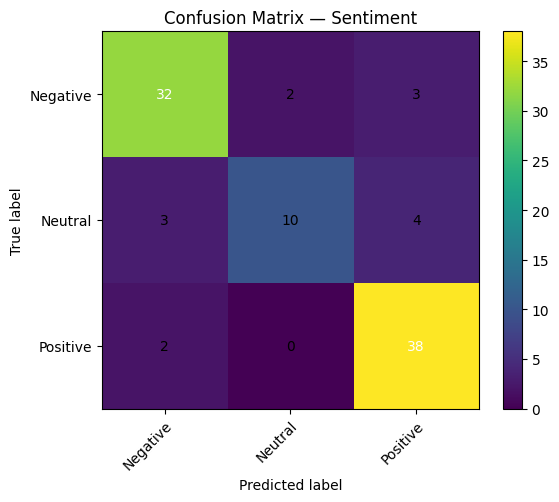

=== CATEGORY (BoW + MultinomialNB) — TEST REPORT ===
                                precision    recall  f1-score   support

Industri & Pariwisata Nasional     0.0000    0.0000    0.0000         1
            Kinerja & Keuangan     0.5652    0.7222    0.6341        18
          Krisis & Kontroversi     0.9355    0.8529    0.8923        34
       Operasional & Pelayanan     0.7895    0.7895    0.7895        38
          Regulasi & Kebijakan     0.5000    0.3333    0.4000         3

                      accuracy                         0.7766        94
                     macro avg     0.5580    0.5396    0.5432        94
                  weighted avg     0.7817    0.7766    0.7761        94



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


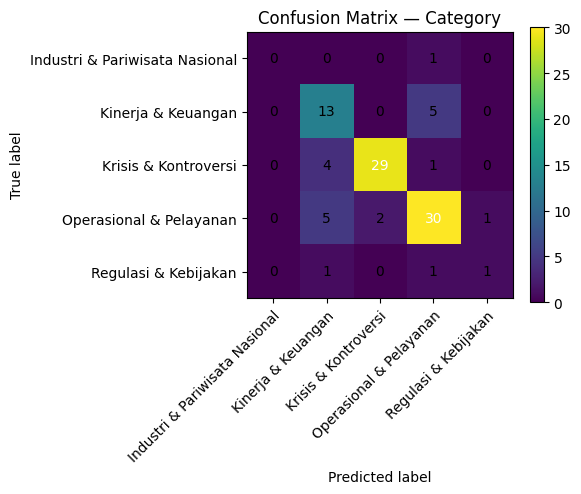


=== RANGKUMAN METRIK (TEST) ===
{'sentiment_test': {'accuracy': 0.8511, 'precision_macro': np.float64(0.8475), 'recall_macro': np.float64(0.801), 'f1_macro': np.float64(0.8162)}, 'category_test': {'accuracy': 0.7766, 'precision_macro': np.float64(0.558), 'recall_macro': np.float64(0.5396), 'f1_macro': np.float64(0.5432)}}


In [12]:
def plot_confusion_matrix(y_true, y_pred, title):
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=labels, yticklabels=labels,
        ylabel='True label', xlabel='Predicted label',
        title=f'Confusion Matrix — {title}'
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

def summarize_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return {
        "accuracy": round(acc, 4),
        "precision_macro": round(p, 4),
        "recall_macro": round(r, 4),
        "f1_macro": round(f1, 4),
    }

# --- Sentiment ---
print("=== SENTIMENT (BoW + MultinomialNB) — TEST REPORT ===")
y_sent_pred = pipe_sent.predict(X_test)
print(classification_report(y_sent_test, y_sent_pred, digits=4))
plot_confusion_matrix(y_sent_test, y_sent_pred, title="Sentiment")

# --- Category ---
print("=== CATEGORY (BoW + MultinomialNB) — TEST REPORT ===")
y_cat_pred = pipe_cat.predict(X_test)
print(classification_report(y_cat_test, y_cat_pred, digits=4))
plot_confusion_matrix(y_cat_test, y_cat_pred, title="Category")

# --- Ringkasan metrik untuk laporan ---
summary_test = {
    "sentiment_test": summarize_metrics(y_sent_test, y_sent_pred),
    "category_test":  summarize_metrics(y_cat_test,  y_cat_pred),
}
print("\n=== RANGKUMAN METRIK (TEST) ===")
print(summary_test)

# Baseline 5 Fold Cross Validation

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


=== 5-FOLD CV (TRAIN) — SENTIMENT (BoW+MNB) ===


,fold,accuracy,precision_macro,recall_macro,f1_macro
0,1,0.7867,0.7498,0.7588,0.7505
1,2,0.8133,0.7830,0.7427,0.7520
2,3,0.8267,0.8040,0.7912,0.7934
3,4,0.7733,0.7345,0.7408,0.7341
4,5,0.8267,0.7778,0.7698,0.7712


Ringkasan (mean ± std) — SENTIMENT


/tmp/ipython-input-374363665.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: round(float(x), 4))


,accuracy,precision_macro,recall_macro,f1_macro
mean,0.8053,0.7698,0.7607,0.7603
std,0.0242,0.0276,0.0208,0.0227



=== 5-FOLD CV (TRAIN) — CATEGORY (BoW+MNB) ===


,fold,accuracy,precision_macro,recall_macro,f1_macro
0,1,0.7333,0.6857,0.6670,0.6749
1,2,0.7867,0.6165,0.5870,0.5889
2,3,0.7733,0.5734,0.5447,0.5450
3,4,0.8133,0.6251,0.6023,0.6032
4,5,0.7333,0.6560,0.5334,0.5638


Ringkasan (mean ± std) — CATEGORY


/tmp/ipython-input-374363665.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: round(float(x), 4))


,accuracy,precision_macro,recall_macro,f1_macro
mean,0.7680,0.6314,0.5869,0.5952
std,0.0348,0.0424,0.0531,0.0499


/tmp/ipython-input-374363665.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=metrics, showmeans=True)


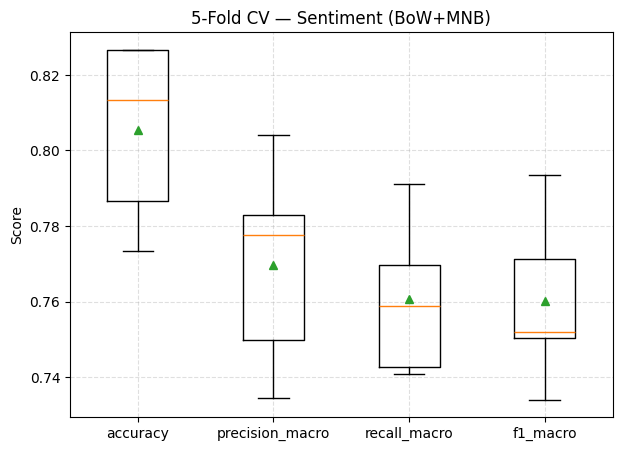

/tmp/ipython-input-374363665.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=metrics, showmeans=True)


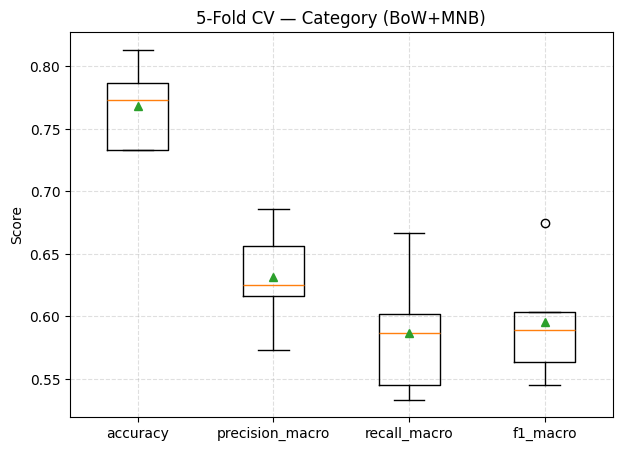

In [13]:
# Safety check
try:
    _ = pipe_sent, pipe_cat, X_train, y_sent_train, y_cat_train
except NameError:
    raise RuntimeError("Pipeline/variabel train belum ada. Jalankan Step 2 & 3 dulu.")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def run_cv(model, X_tr, y_tr, title: str):
    scores = cross_validate(
        model, X_tr, y_tr, cv=cv,
        scoring=["accuracy","precision_macro","recall_macro","f1_macro"],
        n_jobs=-1, return_train_score=False
    )
    # Buat DataFrame per-fold
    df_scores = pd.DataFrame({
        "fold": np.arange(1, len(scores["test_accuracy"])+1),
        "accuracy": scores["test_accuracy"],
        "precision_macro": scores["test_precision_macro"],
        "recall_macro": scores["test_recall_macro"],
        "f1_macro": scores["test_f1_macro"],
    })
    # Ringkasan mean±std
    summary = df_scores[["accuracy","precision_macro","recall_macro","f1_macro"]].agg(["mean","std"])
    return df_scores, summary

# Jalankan CV untuk dua tugas
sent_cv_df, sent_cv_summary = run_cv(pipe_sent, X_train, y_sent_train, "Sentiment (BoW+MNB)")
cat_cv_df,  cat_cv_summary  = run_cv(pipe_cat,  X_train, y_cat_train,  "Category (BoW+MNB)")

# ===== TAMPILKAN HASIL RAPIH =====

def fmt_summary(df_summary: pd.DataFrame):
    df = df_summary.copy()
    return df.applymap(lambda x: round(float(x), 4))

print("=== 5-FOLD CV (TRAIN) — SENTIMENT (BoW+MNB) ===")
display(sent_cv_df.style.format({
    "accuracy": "{:.4f}", "precision_macro": "{:.4f}",
    "recall_macro": "{:.4f}", "f1_macro": "{:.4f}"
}))

print("Ringkasan (mean ± std) — SENTIMENT")
display(fmt_summary(sent_cv_summary))

print("\n=== 5-FOLD CV (TRAIN) — CATEGORY (BoW+MNB) ===")
display(cat_cv_df.style.format({
    "accuracy": "{:.4f}", "precision_macro": "{:.4f}",
    "recall_macro": "{:.4f}", "f1_macro": "{:.4f}"
}))

print("Ringkasan (mean ± std) — CATEGORY")
display(fmt_summary(cat_cv_summary))

# ===== OPTIONAL: BOXPLOT untuk visualisasi sebaran per metrik =====
def boxplot_metrics(df_scores: pd.DataFrame, title: str):
    metrics = ["accuracy","precision_macro","recall_macro","f1_macro"]
    data = [df_scores[m].values for m in metrics]
    plt.figure(figsize=(7,5))
    plt.boxplot(data, labels=metrics, showmeans=True)
    plt.title(f"5-Fold CV — {title}")
    plt.ylabel("Score")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()

boxplot_metrics(sent_cv_df, "Sentiment (BoW+MNB)")
boxplot_metrics(cat_cv_df,  "Category (BoW+MNB)")

In [14]:
test_df = pd.DataFrame({
    "text": X_test,
    "true_sent": y_sent_test,
    "true_cat": y_cat_test
})

# Prediksi
test_df["pred_sent"] = pipe_sent.predict(X_test)
test_df["pred_cat"]  = pipe_cat.predict(X_test)

# 7a) Tampilkan beberapa contoh salah prediksi (Sentiment)
mist_sent = test_df[test_df["true_sent"] != test_df["pred_sent"]].copy()
print(f"Jumlah salah prediksi SENTIMENT: {len(mist_sent)}")
display(mist_sent[["text","true_sent","pred_sent"]].head(10))

# 7b) Tampilkan beberapa contoh salah prediksi (Category)
mist_cat = test_df[test_df["true_cat"] != test_df["pred_cat"]].copy()
print(f"\nJumlah salah prediksi CATEGORY: {len(mist_cat)}")
display(mist_cat[["text","true_cat","pred_cat"]].head(10))

# 7c) Pasangan kelas yang paling sering tertukar (Sentiment)
labels_sent = np.unique(y_sent_test)
cm_sent = confusion_matrix(y_sent_test, test_df["pred_sent"], labels=labels_sent)
cm_sent_df = pd.DataFrame(cm_sent, index=labels_sent, columns=labels_sent)
cm_sent_long = cm_sent_df.stack().rename("count").reset_index().rename(columns={"level_0":"true","level_1":"pred"})
cm_sent_long = cm_sent_long[cm_sent_long["true"] != cm_sent_long["pred"]].sort_values("count", ascending=False)
print("\nPairs paling sering tertukar — SENTIMENT:")
display(cm_sent_long.head(10))

# 7d) Pasangan kelas yang paling sering tertukar (Category)
labels_cat = np.unique(y_cat_test)
cm_cat = confusion_matrix(y_cat_test, test_df["pred_cat"], labels=labels_cat)
cm_cat_df = pd.DataFrame(cm_cat, index=labels_cat, columns=labels_cat)
cm_cat_long = cm_cat_df.stack().rename("count").reset_index().rename(columns={"level_0":"true","level_1":"pred"})
cm_cat_long = cm_cat_long[cm_cat_long["true"] != cm_cat_long["pred"]].sort_values("count", ascending=False)
print("\nPairs paling sering tertukar — CATEGORY:")
display(cm_cat_long.head(10))

Jumlah salah prediksi SENTIMENT: 14


,text,true_sent,pred_sent
1,viral pemuda naik pesawat garuda indonesia gra...,Positive,Negative
12,tempo cowok jakarta anggota dpr airlangga hart...,Negative,Positive
17,garuda indonesia ungkap alas harga tiket pesaw...,Negative,Neutral
20,pt garuda indonesia tbk giaa catat naik jumlah...,Neutral,Positive
22,majelis hakim jatuh vonis bebas usaha soetikno...,Positive,Negative
36,mohamad john garuda putra aku diri dapat serti...,Neutral,Negative
43,latar belakang tengah wacana konsolidasi maska...,Neutral,Positive
46,tangerang selatan kompas penuh minta tingkat p...,Neutral,Positive
49,isu gabung pt garuda indonesia persero tbk ser...,Negative,Neutral
55,jakarta kompas com jumlah terbang garuda indon...,Neutral,Negative



Jumlah salah prediksi CATEGORY: 21


,text,true_cat,pred_cat
0,tempo cowok jakarta garuda datang pesawat baru...,Operasional & Pelayanan,Kinerja & Keuangan
1,viral pemuda naik pesawat garuda indonesia gra...,Operasional & Pelayanan,Krisis & Kontroversi
5,sabre a new agreement with garuda indonesia th...,Operasional & Pelayanan,Kinerja & Keuangan
6,menteri bumn erick thohir buka suara kait pt g...,Krisis & Kontroversi,Kinerja & Keuangan
8,jakarta cnbc indonesia maskapai pelat merah pt...,Kinerja & Keuangan,Operasional & Pelayanan
13,jakarta cnbc indonesia tengah mahal naik harga...,Kinerja & Keuangan,Operasional & Pelayanan
15,garuda indonesia tak kuat bayar biaya awat pes...,Krisis & Kontroversi,Kinerja & Keuangan
25,jakarta cnbc indonesia pt garuda indonesia per...,Krisis & Kontroversi,Operasional & Pelayanan
27,pt garuda indonesia persero tbk kabar henti op...,Krisis & Kontroversi,Kinerja & Keuangan
37,garuda gelar rupslb tengah isu masuk direksi a...,Regulasi & Kebijakan,Kinerja & Keuangan



Pairs paling sering tertukar — SENTIMENT:


,true,pred,count
5,Neutral,Positive,4
2,Negative,Positive,3
3,Neutral,Negative,3
1,Negative,Neutral,2
6,Positive,Negative,2
7,Positive,Neutral,0



Pairs paling sering tertukar — CATEGORY:


,true,pred,count
16,Operasional & Pelayanan,Kinerja & Keuangan,5
8,Kinerja & Keuangan,Operasional & Pelayanan,5
11,Krisis & Kontroversi,Kinerja & Keuangan,4
17,Operasional & Pelayanan,Krisis & Kontroversi,2
21,Regulasi & Kebijakan,Kinerja & Keuangan,1
19,Operasional & Pelayanan,Regulasi & Kebijakan,1
13,Krisis & Kontroversi,Operasional & Pelayanan,1
3,Industri & Pariwisata Nasional,Operasional & Pelayanan,1
23,Regulasi & Kebijakan,Operasional & Pelayanan,1
4,Industri & Pariwisata Nasional,Regulasi & Kebijakan,0


In [15]:
def top_features_per_class(pipe, topk=15):
    vec = pipe.named_steps["vec"]
    clf = pipe.named_steps["clf"]

    # get feature names
    try:
        feat_names = vec.get_feature_names_out()
    except:
        feat_names = vec.get_feature_names()

    # log prob per class (shape: n_classes x n_features)
    log_prob = clf.feature_log_prob_  # MultinomialNB
    classes = clf.classes_

    frames = []
    for ci, cls in enumerate(classes):
        # ambil topk fitur berdasarkan log_prob
        idx = np.argsort(log_prob[ci])[::-1][:topk]
        frames.append(pd.DataFrame({
            "class": cls,
            "feature": feat_names[idx],
            "log_prob": log_prob[ci][idx]
        }))
    return pd.concat(frames, ignore_index=True)

print("=== Top Features — SENTIMENT (per kelas) ===")
top_sent = top_features_per_class(pipe_sent, topk=15)
display(top_sent)

print("\n=== Top Features — CATEGORY (per kelas) ===")
top_cat = top_features_per_class(pipe_cat, topk=15)
display(top_cat)


=== Top Features — SENTIMENT (per kelas) ===


,class,feature,log_prob
0,Negative,garuda,-4.314267
1,Negative,pesawat,-4.389968
2,Negative,indonesia,-4.542825
3,Negative,garuda indonesia,-4.690024
4,Negative,terbang,-4.787696
5,Negative,sebut,-5.004717
6,Negative,tumpang,-5.073454
7,Negative,jadi,-5.435638
8,Negative,laku,-5.438404
9,Negative,bandara,-5.681836



=== Top Features — CATEGORY (per kelas) ===


,class,feature,log_prob
0,Industri & Pariwisata Nasional,indonesia,-6.691020
1,Industri & Pariwisata Nasional,air,-6.739810
2,Industri & Pariwisata Nasional,maskapai,-7.027492
3,Industri & Pariwisata Nasional,garuda,-7.027492
4,Industri & Pariwisata Nasional,garuda indonesia,-7.250636
...,...,...,...
70,Regulasi & Kebijakan,turun,-6.129831
71,Regulasi & Kebijakan,jakarta,-6.249975
72,Regulasi & Kebijakan,laku,-6.249975
73,Regulasi & Kebijakan,jadi,-6.271481


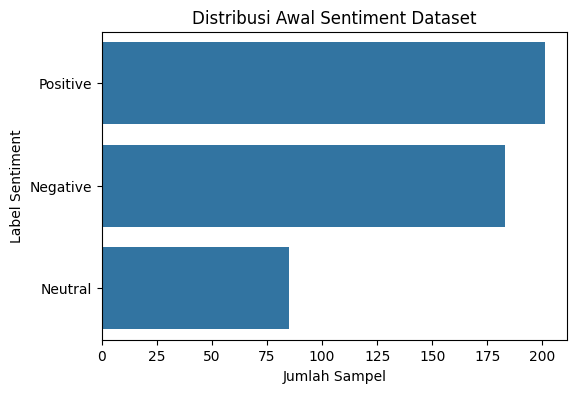

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(y="sentiment", data=df_base, order=df_base["sentiment"].value_counts().index)
plt.title("Distribusi Awal Sentiment Dataset")
plt.xlabel("Jumlah Sampel")
plt.ylabel("Label Sentiment")
plt.show()

# Augmentation

In [17]:
!pip -q install nlpaug==1.1.11 nltk==3.9.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.0 MB/s eta 0:00:00


In [18]:
import nlpaug.augmenter.word as naw

In [19]:
aug_syn = naw.SynonymAug(aug_src='wordnet', aug_p=0.2)  # 20% kata diganti sinonim

# ambil contoh untuk augmentasi hanya pada kelas minor
sent_counts = df_base["sentiment"].value_counts()
minor_classes = sent_counts[sent_counts < sent_counts.max()].index.tolist()

print("Kelas minor yang akan diaugmentasi:", minor_classes)

aug_texts = []
aug_labels = []

# augmentasi untuk kelas minor saja
for cls in minor_classes:
    subset = df_base[df_base["sentiment"] == cls]
    target_count = sent_counts.max() - len(subset)
    sample_rows = subset.sample(target_count, replace=True, random_state=42)

    for t in sample_rows["konten_stem_clean"]:
        try:
            new_text = aug_syn.augment(t)
        except:
            new_text = t
        aug_texts.append(new_text)
        aug_labels.append(cls)

# gabung data augmented dengan data asli
df_aug = pd.concat([
    df_base,
    pd.DataFrame({
        "konten_stem_clean": aug_texts,
        "sentiment": aug_labels,
        "tag_new": np.random.choice(df_base["tag_new"], len(aug_texts))
    })
]).reset_index(drop=True)

print(f"Data sebelum augmentasi: {len(df_base)}")
print(f"Data setelah augmentasi: {len(df_aug)}")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Kelas minor yang akan diaugmentasi: ['Negative', 'Neutral']


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...


Data sebelum augmentasi: 469
Data setelah augmentasi: 603


[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already 

# Data Distribution Preview

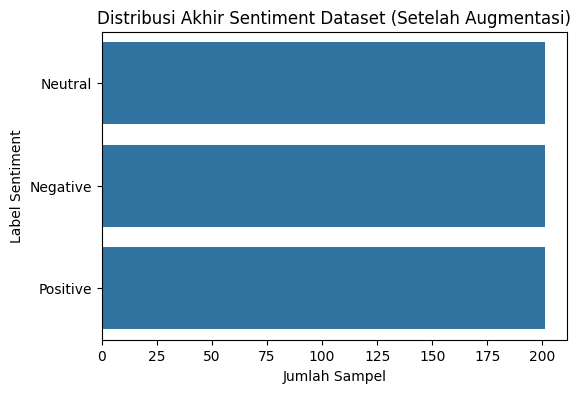

Distribusi baru:
sentiment
Neutral     201
Negative    201
Positive    201
Name: count, dtype: int64


In [20]:
plt.figure(figsize=(6,4))
sns.countplot(y="sentiment", data=df_aug, order=df_aug["sentiment"].value_counts().index)
plt.title("Distribusi Akhir Sentiment Dataset (Setelah Augmentasi)")
plt.xlabel("Jumlah Sampel")
plt.ylabel("Label Sentiment")
plt.show()

print("Distribusi baru:")
print(df_aug["sentiment"].value_counts())

#Augmented Data Evaluation

In [21]:
X_aug = df_aug["konten_stem_clean"].astype(str).values
y_aug_sent = df_aug["sentiment"].astype(str).values
y_aug_cat  = df_aug["tag_new"].astype(str).values

X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    X_aug, y_aug_sent, test_size=0.2, random_state=42, stratify=y_aug_sent
)

# Train ulang model sentiment
pipe_sent_aug = make_baseline_pipeline()
pipe_sent_aug.fit(X_train_aug, y_train_aug)

y_pred_aug = pipe_sent_aug.predict(X_test_aug)

print("=== HASIL MODEL (SETELAH AUGMENTASI) ===")
print(classification_report(y_test_aug, y_pred_aug, digits=4))


=== HASIL MODEL (SETELAH AUGMENTASI) ===
              precision    recall  f1-score   support

    Negative     0.9444    0.8500    0.8947        40
     Neutral     0.8537    0.8750    0.8642        40
    Positive     0.9091    0.9756    0.9412        41

    accuracy                         0.9008       121
   macro avg     0.9024    0.9002    0.9000       121
weighted avg     0.9025    0.9008    0.9004       121



# Model Comparison


In [22]:
# STEP 4.1 — Dataset asli (tanpa augmentasi)
X_raw = df_base["konten_stem_clean"].astype(str).values
y_raw_sent = df_base["sentiment"].astype(str).values

from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw_sent, test_size=0.2, random_state=42, stratify=y_raw_sent
)

print(f"Train: {len(X_train_raw)}, Test: {len(X_test_raw)}")
print("Distribusi Sentiment (train):")
print(pd.Series(y_train_raw).value_counts(normalize=True).round(3))


Train: 375, Test: 94
Distribusi Sentiment (train):
Positive    0.429
Negative    0.389
Neutral     0.181
Name: proportion, dtype: float64


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [24]:
models = {
    # Grup A: BoW
    "BoW + MNB": Pipeline([
        ("vec", CountVectorizer(ngram_range=(1,2), min_df=2)),
        ("clf", MultinomialNB(alpha=1.0))
    ]),
    "BoW + LogisticRegression": Pipeline([
        ("vec", CountVectorizer(ngram_range=(1,2), min_df=2)),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "BoW + LinearSVM": Pipeline([
        ("vec", CountVectorizer(ngram_range=(1,2), min_df=2)),
        ("clf", LinearSVC(random_state=42))
    ]),

    # Grup B: TF-IDF
    "TF-IDF + MNB": Pipeline([
        ("vec", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
        ("clf", MultinomialNB(alpha=1.0))
    ]),
    "TF-IDF + LogisticRegression": Pipeline([
        ("vec", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "TF-IDF + LinearSVM": Pipeline([
        ("vec", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
        ("clf", LinearSVC(random_state=42))
    ]),
}

In [25]:
# --- fungsi evaluasi ---
def evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0)
    return {
        "accuracy": round(acc, 4),
        "precision_macro": round(p, 4),
        "recall_macro": round(r, 4),
        "f1_macro": round(f1, 4)
    }

# --- jalankan semua model ---
results = {name: evaluate(m, X_train_raw, X_test_raw, y_train_raw, y_test_raw)
           for name, m in models.items()}

res_df = pd.DataFrame(results).T.sort_values("f1_macro", ascending=False)
print("=== HASIL PERBANDINGAN MODEL (6 Model) ===")
display(res_df)

=== HASIL PERBANDINGAN MODEL (6 Model) ===


,accuracy,precision_macro,recall_macro,f1_macro
BoW + MNB,0.8511,0.8475,0.8010,0.8162
BoW + LinearSVM,0.7872,0.7491,0.7292,0.7347
TF-IDF + LinearSVM,0.7872,0.7907,0.6841,0.6830
BoW + LogisticRegression,0.7447,0.6826,0.6613,0.6620
TF-IDF + LogisticRegression,0.7447,0.8281,0.6162,0.5778
TF-IDF + MNB,0.7340,0.4929,0.5959,0.5379
